## 전통적 시계열 모델링

### 1. 환경준비

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as spst
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import *
from sklearn.model_selection import train_test_split

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore')
warnings.simplefilter('ignore', ConvergenceWarning)

In [2]:
# 결과 시각화 함수
def plot_model_result(y_train, y_val, pred) :
    pred = pd.Series(pred, index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

In [3]:
# 잔차분석 함수
def residual_diag(residuals, lags = 30) :
    print('* 정규성 검정(> 0.05) : ', round(spst.shapiro(residuals)[1],5))
    print('* 정상성 검정(< 0.05) : ', round(sm.tsa.stattools.adfuller(residuals)[1],5))
    print('* 자기상관성 확인(ACF, PACF)')
    fig,ax = plt.subplots(1,2, figsize = (15,5))
    plot_acf(residuals, lags = lags, ax = ax[0])
    plot_pacf(residuals, lags = lags, ax = ax[1])
    plt.show()

In [4]:
# 데이터 불러오기
path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/retail_demand2.csv'
data = pd.read_csv(path, usecols = ['date', 'sales'])
data = data.loc[data['date']<= '2014-10-31'].reset_index(drop = True)
data['date'] = pd.to_datetime(data['date'])
data['weekday'] = data['date'].dt.day_name().str.slice(0,3)
data.head()

,date,sales,weekday
0,2013-01-01,45,Tue
1,2013-01-02,53,Wed
2,2013-01-03,65,Thu
3,2013-01-04,66,Fri
4,2013-01-05,97,Sat


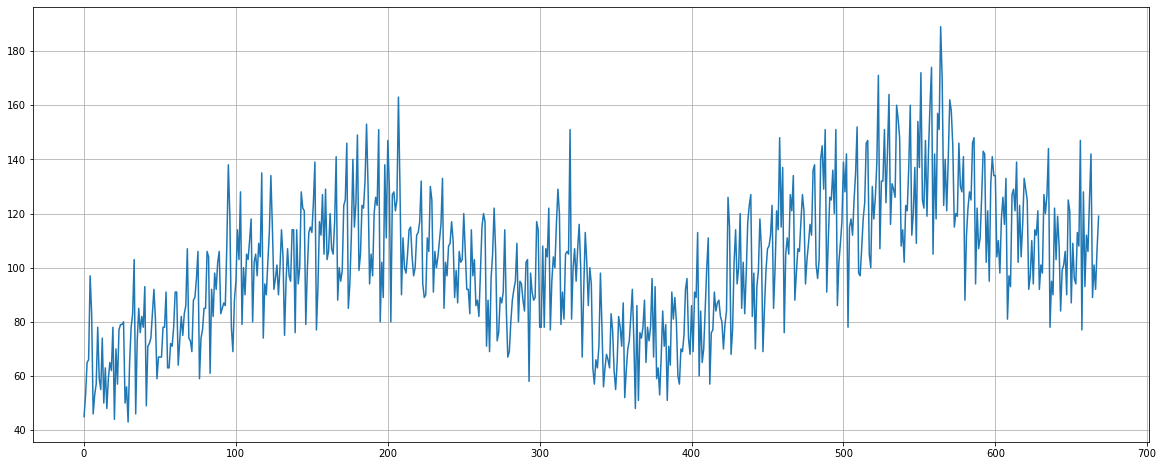

In [5]:
plt.figure(figsize = (20,8))
plt.plot(data['sales'])
plt.grid()
plt.show()

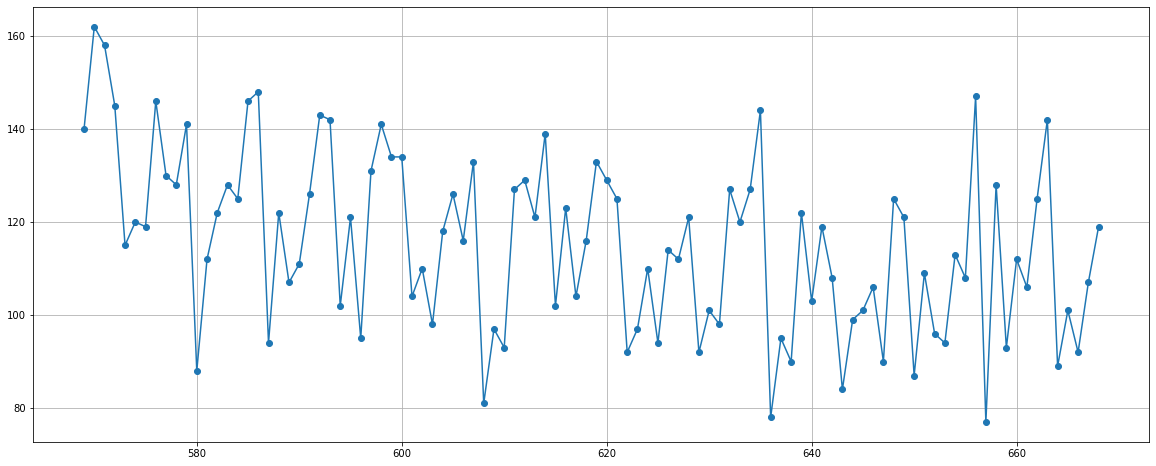

In [6]:
temp = data[-100:]
plt.figure(figsize = (20,8))
plt.plot(temp['sales'], marker ='o')
plt.grid()
plt.show()

### 2. 기본 전처리

In [7]:
# y 만들기
data['y'] = data['sales'].shift(-1)
display(data.head())
display(data.tail())

,date,sales,weekday,y
0,2013-01-01,45,Tue,53.0
1,2013-01-02,53,Wed,65.0
2,2013-01-03,65,Thu,66.0
3,2013-01-04,66,Fri,97.0
4,2013-01-05,97,Sat,83.0


,date,sales,weekday,y
664,2014-10-27,89,Mon,101.0
665,2014-10-28,101,Tue,92.0
666,2014-10-29,92,Wed,107.0
667,2014-10-30,107,Thu,119.0
668,2014-10-31,119,Fri,NaN


In [8]:
data.dropna(axis = 0, inplace = True)
data.tail()

,date,sales,weekday,y
663,2014-10-26,142,Sun,89.0
664,2014-10-27,89,Mon,101.0
665,2014-10-28,101,Tue,92.0
666,2014-10-29,92,Wed,107.0
667,2014-10-30,107,Thu,119.0


In [9]:
# x, y 나누기
target = 'y'
x = data.drop([target, 'date'], axis = 1)
y = data.loc[:, target]

In [10]:
# train, val 나누기
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 30, shuffle = False)

### 3. 모델링1 : ARIMA

- y가 Stationary 해야 함.
    - 평균, 분산, 공분산이 일정.
    
    
- 차분 (변화량)
    - AR과 MA를 결합할 것.
    - 데이터가 Stationary하지 않을 때 차분을 진행한 것이 ARIMA.

* 정규성 검정(> 0.05) :  0.00853
* 정상성 검정(< 0.05) :  0.27897
* 자기상관성 확인(ACF, PACF)


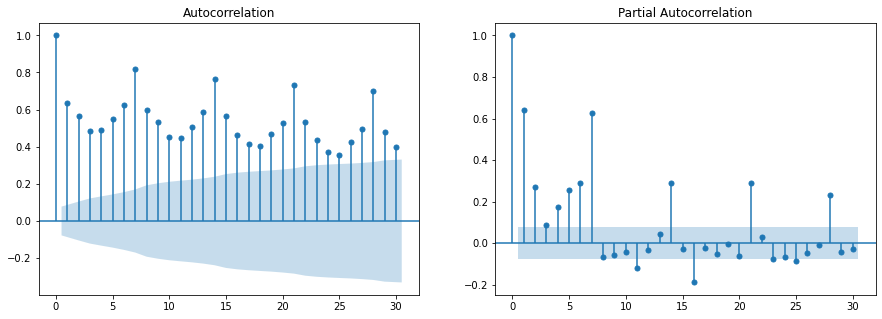

In [11]:
# y값 살펴보기 (모델링 하지 않은 채로 잔차 확인)
residual_diag(y_train, lags = 30)

- 실제값 = 모델 + 잔차
- 잔차 = y_train인 상태에서 정규성, 정상성 검정.
- 모델을 만들어서 검정하면 차이가 줄어들 것으로 예상.

#### 모델링 : 초기모델

- p, d, q 값을 어떻게 정해야 할지?
- AR의 p 차수와 MA의 q 차수 모두 값이 필요하다.

In [12]:
# ARIMA 모델링
m1_1 = sm.tsa.SARIMAX(y_train, order=(1,0,1)).fit() # d가 0이면 ARMA와 같은 모델
m1_2 = sm.tsa.SARIMAX(y_train, order=(1,1,1)).fit()

#### 평가

- 1. 잔차진단

* 정규성 검정(> 0.05) :  0.38791
* 정상성 검정(< 0.05) :  0.00088
* 자기상관성 확인(ACF, PACF)


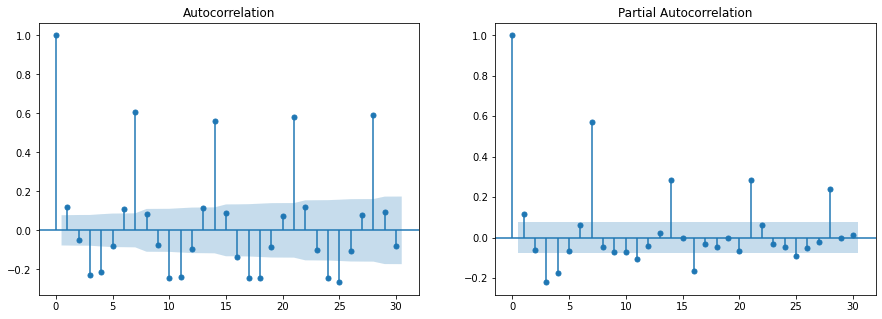

In [13]:
residuals = m1_1.resid
residual_diag(residuals)

* 정규성 검정(> 0.05) :  0.07599
* 정상성 검정(< 0.05) :  0.00115
* 자기상관성 확인(ACF, PACF)


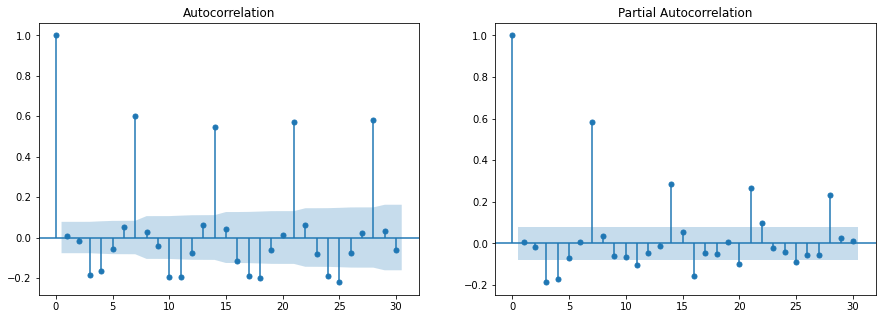

In [14]:
residuals = m1_2.resid
residual_diag(residuals)

- 2. AIC
    - 선형 모델에서의 적합도, feature가 과도하게 늘어나는 것을 방지.
    - 값이 작을 수록 좋은 모델.
    - 공식 : 𝐴𝐼𝐶=−2 ln⁡(𝐿)+2𝑘 ➡ - 모델의 적합도 + 변수의 갯수

In [15]:
print('model1 AIC :', m1_1.aic)
print('model2 AIC :', m1_2.aic)

model1 AIC : 5464.670363960708
model2 AIC : 5442.769868773823


- 3. Validation

    - 시계열 데이터로 실제값과 예측값에 대해 비교하여 시각화

In [16]:
pred = m1_1.forecast(30)
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))

MAE : 12.918460959652306
MAPE: 0.12228691428354797


In [17]:
pred = m1_2.forecast(30)
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))

MAE : 13.123421572150058
MAPE: 0.12539084122967378


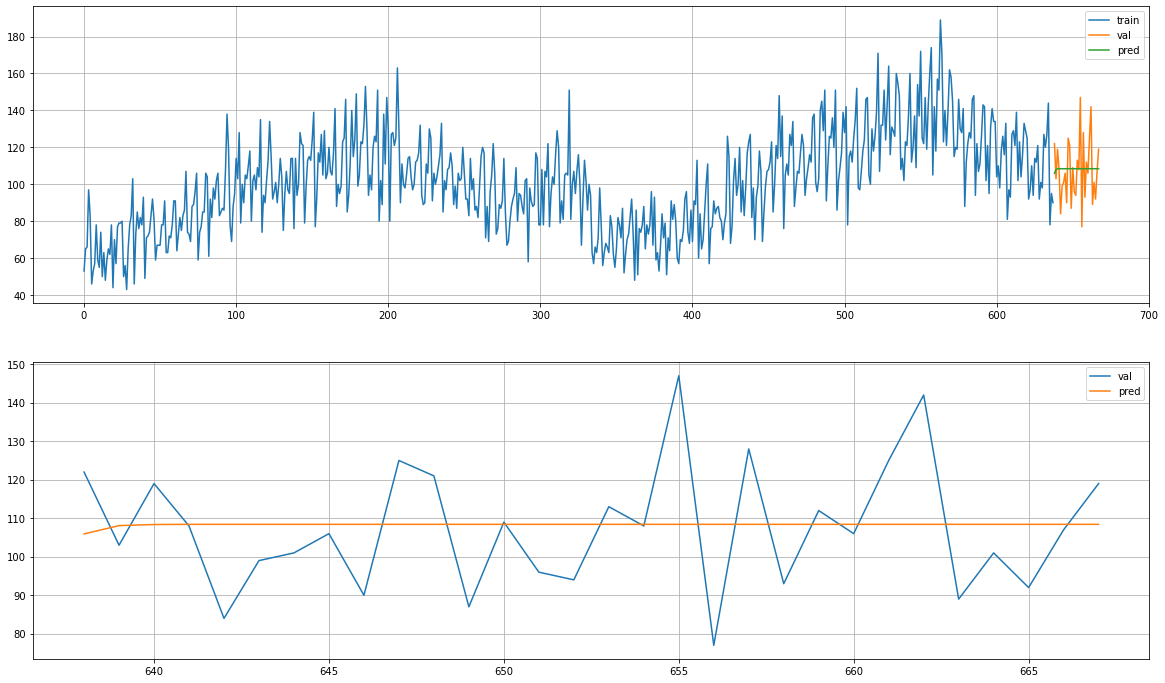

In [18]:
plot_model_result(y_train, y_val, pred)

#### 하이퍼 파라미터 튜닝

#### 1) 학습

- 값의 범위 지정

In [19]:
from itertools import product

In [20]:
# product 함수를 이용하여 값의 조합을 구성
p = [1,2,3,4]
q = [1,2,3,4]
d = [1]
iter = list(product(p,d,q))
iter

[(1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (1, 1, 4),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (2, 1, 4),
 (3, 1, 1),
 (3, 1, 2),
 (3, 1, 3),
 (3, 1, 4),
 (4, 1, 1),
 (4, 1, 2),
 (4, 1, 3),
 (4, 1, 4)]

- 튜닝

In [21]:
mae, aic = [],[]
for i in iter :
    model_fit = sm.tsa.SARIMAX(y_train, order=(i[0],i[1],i[2])).fit()
    pred = model_fit.forecast(30)
    mae.append( mean_absolute_error(y_val, pred))
    aic.append(model_fit.aic)
    print(i)

(1, 1, 1)
(1, 1, 2)
(1, 1, 3)
(1, 1, 4)
(2, 1, 1)
(2, 1, 2)
(2, 1, 3)
(2, 1, 4)
(3, 1, 1)
(3, 1, 2)
(3, 1, 3)
(3, 1, 4)
(4, 1, 1)
(4, 1, 2)
(4, 1, 3)
(4, 1, 4)


In [22]:
result = pd.DataFrame({'params(p,d,q)' : iter, 'mae' : mae, 'aic':aic})

display(result.loc[result['mae'] == result.mae.min()])
display(result.loc[result['aic'] == result.aic.min()])

,"params(p,d,q)",mae,aic
11,"(3, 1, 4)",11.057151,5219.319721


,"params(p,d,q)",mae,aic
10,"(3, 1, 3)",11.5905,5171.92015


In [23]:
result

,"params(p,d,q)",mae,aic
0,"(1, 1, 1)",13.123422,5442.769869
1,"(1, 1, 2)",13.136196,5439.502307
2,"(1, 1, 3)",13.098455,5442.860648
3,"(1, 1, 4)",12.958563,5391.056782
4,"(2, 1, 1)",13.108983,5443.032758
5,"(2, 1, 2)",13.159205,5437.968365
6,"(2, 1, 3)",12.806870,5409.107320
7,"(2, 1, 4)",12.952655,5393.052762
8,"(3, 1, 1)",12.902352,5406.736006
9,"(3, 1, 2)",12.680277,5339.585835


In [24]:
m1_3 = sm.tsa.SARIMAX(y_train, order=(3,1,3)).fit()

#### 2) 평가

- 1. 잔차진단

* 정규성 검정(> 0.05) :  0.00652
* 정상성 검정(< 0.05) :  4e-05
* 자기상관성 확인(ACF, PACF)


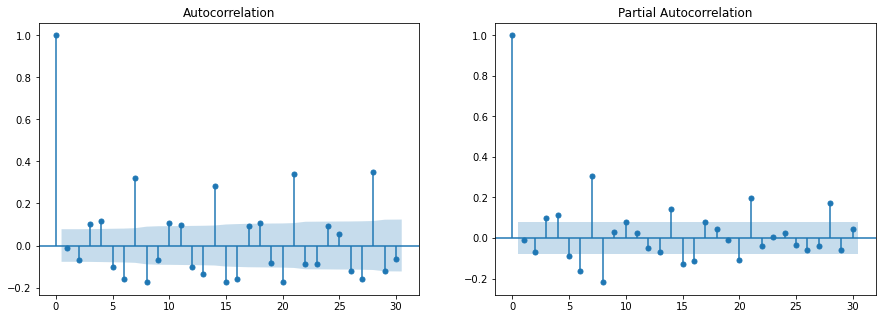

In [25]:
residuals = m1_3.resid
residual_diag(residuals)

- 2. AIC

In [26]:
print('model2 AIC :', m1_3.aic)

model2 AIC : 5171.9201501481175


- 3. Validation

In [27]:
pred = m1_3.forecast(30)
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))

MAE : 11.590500479029398
MAPE: 0.11049384327992426


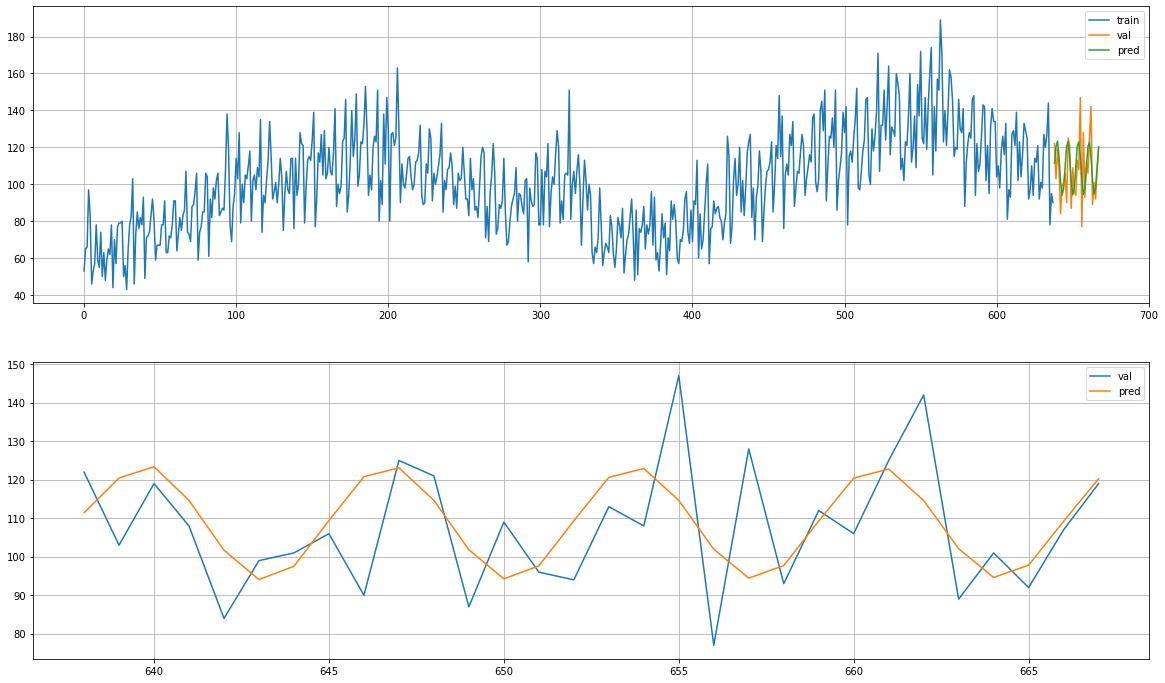

In [28]:
plot_model_result(y_train, y_val, pred)

### 4. 모델링2 : SARIMA

#### 1) 학습

- 값의 범위 지정

In [29]:
m2_1 = sm.tsa.SARIMAX(y_train, order=(3,1,3), seasonal_order=(1,1,1,7)).fit()

#### 2) 평가

- 1. 잔차진단

* 정규성 검정(> 0.05) :  0.00274
* 정상성 검정(< 0.05) :  0.0
* 자기상관성 확인(ACF, PACF)


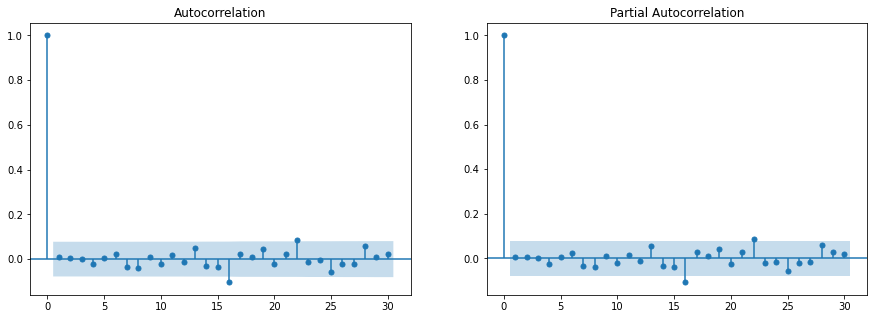

In [30]:
residuals = m2_1.resid
residual_diag(residuals)

- 2. AIC

In [31]:
print('model2_0 AIC :', m2_1.aic)

model2_0 AIC : 4846.302440142703


- 3. Validation

In [32]:
pred = m2_1.forecast(30)
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))

MAE : 7.942958528277967
MAPE: 0.0733998184034363


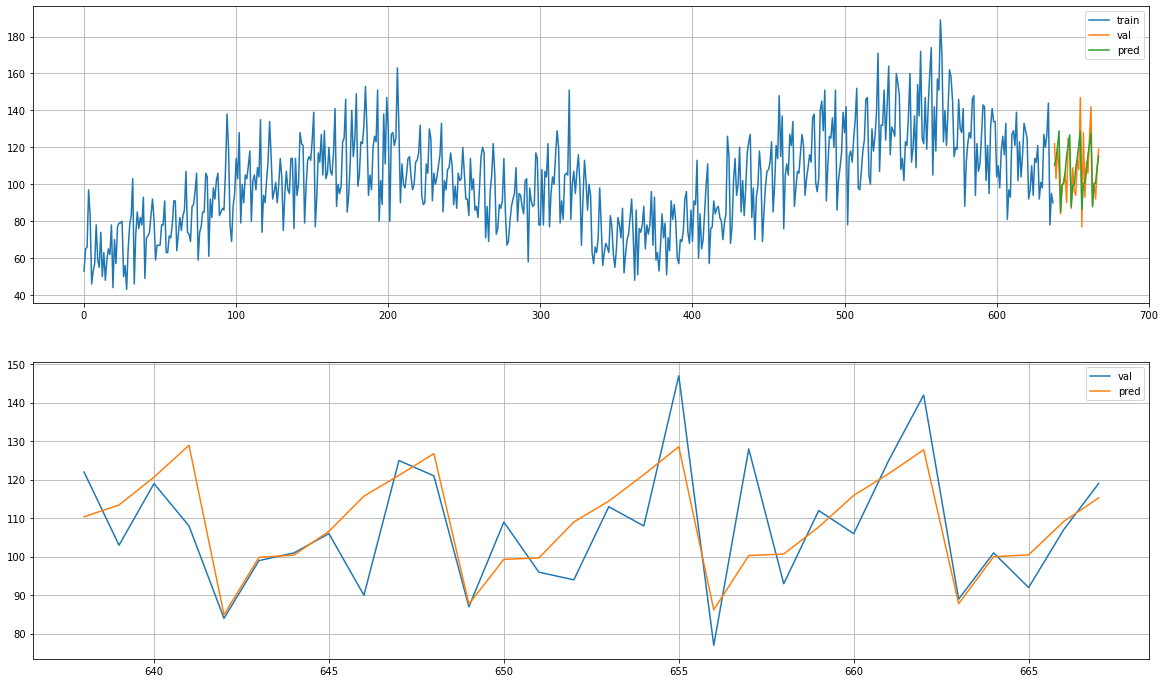

In [33]:
plot_model_result(y_train, y_val, pred)

#### 3) 하이퍼파라미터 튜닝

- 1 학습

In [34]:
P = [1,2,3]
Q = [1,2,3]
D = [1]
mae, aic = [],[]
iter = list(product(P,D,Q))

for i in iter :
    model_fit = sm.tsa.SARIMAX(y_train, order=(3,1,3), seasonal_order=(i[0],i[1],i[2],7)).fit()
    pred = model_fit.forecast(30)
    mae.append( mean_absolute_error(y_val, pred))
    aic.append(model_fit.aic)
    print(i)

(1, 1, 1)
(1, 1, 2)
(1, 1, 3)
(2, 1, 1)
(2, 1, 2)
(2, 1, 3)
(3, 1, 1)
(3, 1, 2)
(3, 1, 3)


In [35]:
result = pd.DataFrame({'params(P,D,Q)' : iter, 'mae' : mae, 'aic':aic})
result

,"params(P,D,Q)",mae,aic
0,"(1, 1, 1)",7.942959,4846.302440
1,"(1, 1, 2)",8.114582,4848.938479
2,"(1, 1, 3)",8.146529,4850.563091
3,"(2, 1, 1)",8.154073,4848.678504
4,"(2, 1, 2)",8.083314,4850.597054
5,"(2, 1, 3)",8.044561,4848.905293
6,"(3, 1, 1)",7.934638,4849.688099
7,"(3, 1, 2)",8.002225,4852.041935
8,"(3, 1, 3)",8.094993,4853.140259


In [36]:
display(result.loc[result['mae'] == result.mae.min()])
display(result.loc[result['aic'] == result.aic.min()])

,"params(P,D,Q)",mae,aic
6,"(3, 1, 1)",7.934638,4849.688099


,"params(P,D,Q)",mae,aic
0,"(1, 1, 1)",7.942959,4846.30244


In [37]:
m2_2 = sm.tsa.SARIMAX(y_train, order=(3,1,3), seasonal_order=(1,1,1,7)).fit()
m2_3 = sm.tsa.SARIMAX(y_train, order=(3,1,3), seasonal_order=(1,1,1,7)).fit()

- 2. 평가

* 정규성 검정(> 0.05) :  0.00274
* 정상성 검정(< 0.05) :  0.0
* 자기상관성 확인(ACF, PACF)


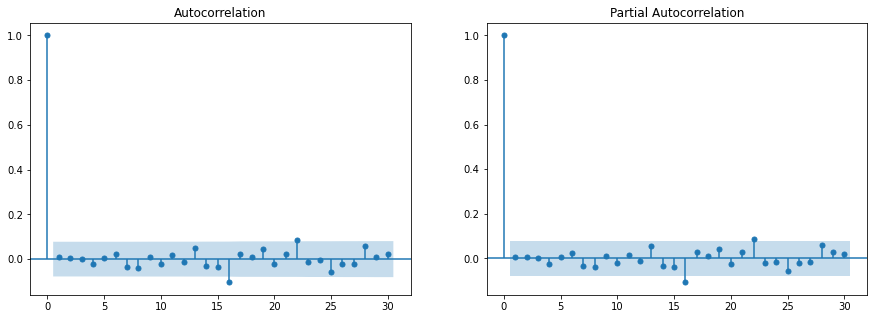

In [38]:
# 잔차진단
residuals = m2_2.resid
residual_diag(residuals)

* 정규성 검정(> 0.05) :  0.00274
* 정상성 검정(< 0.05) :  0.0
* 자기상관성 확인(ACF, PACF)


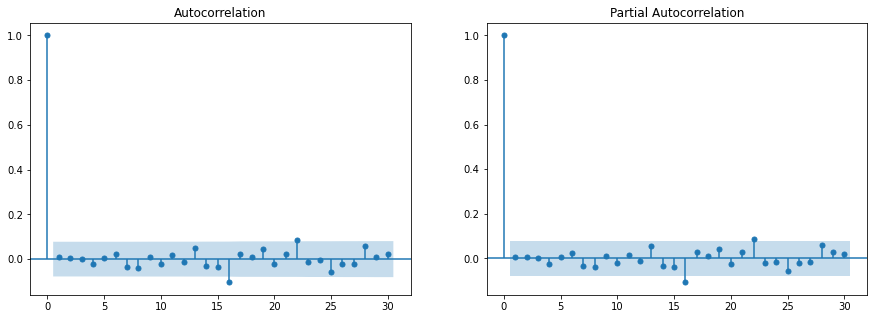

In [39]:
residuals = m2_3.resid
residual_diag(residuals)

In [40]:
# AIC
print('model2_2 AIC :', m2_2.aic)
print('model2_3 AIC :', m2_3.aic)

model2_2 AIC : 4846.302440142703
model2_3 AIC : 4846.302440142703


In [41]:
# Validation
pred = m2_3.forecast(30)
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))

MAE : 7.942958528277967
MAPE: 0.0733998184034363


### 5. 모델링3 : SARIMAX

In [42]:
# 전처리
# 가변수화
x2 = pd.get_dummies(x, columns = ['weekday'], drop_first=False)

# feature engineering
x2['sales_lag7'] = x2['sales'].shift(6)
x2.head(10)

,sales,weekday_Fri,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,sales_lag7
0,45,0,0,0,0,0,1,0,NaN
1,53,0,0,0,0,0,0,1,NaN
2,65,0,0,0,0,1,0,0,NaN
3,66,1,0,0,0,0,0,0,NaN
4,97,0,0,1,0,0,0,0,NaN
5,83,0,0,0,1,0,0,0,NaN
6,46,0,1,0,0,0,0,0,45.0
7,53,0,0,0,0,0,1,0,53.0
8,57,0,0,0,0,0,0,1,65.0
9,78,0,0,0,0,1,0,0,66.0


In [43]:
x3, y3 = x2[6:].copy(), y[6:].copy()

x3.reset_index(drop = True, inplace = True)
y3.reset_index(drop = True, inplace = True)
x3.head()

,sales,weekday_Fri,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,sales_lag7
0,46,0,1,0,0,0,0,0,45.0
1,53,0,0,0,0,0,1,0,53.0
2,57,0,0,0,0,0,0,1,65.0
3,78,0,0,0,0,1,0,0,66.0
4,59,1,0,0,0,0,0,0,97.0


In [45]:
# train, test 나누기
x_train, x_val, y_train, y_val = train_test_split(x3, y3, test_size = 30, shuffle = False)

#### 1) 학습

- exog=x_train 옵션 지정

In [46]:
m3_1 = sm.tsa.SARIMAX(y_train, order=(4,1,4), seasonal_order=(1,1,1,7), exog=x_train).fit()

#### 2) 평가

- 1. 잔차진단

* 정규성 검정(> 0.05) :  0.0
* 정상성 검정(< 0.05) :  0.0
* 자기상관성 확인(ACF, PACF)


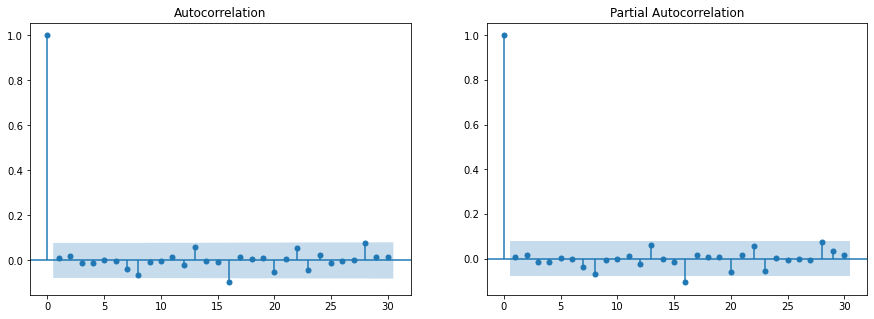

In [47]:
residuals = m3_1.resid
residual_diag(residuals)

- 2. AIC

In [48]:
print('m3_1 AIC :', m3_1.aic)

m3_1 AIC : 4822.819382800159


- 3. Validation

In [49]:
pred = m3_1.forecast(30,  exog=x_val)
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))

MAE : 7.790412607901317
MAPE: 0.07225423363030757


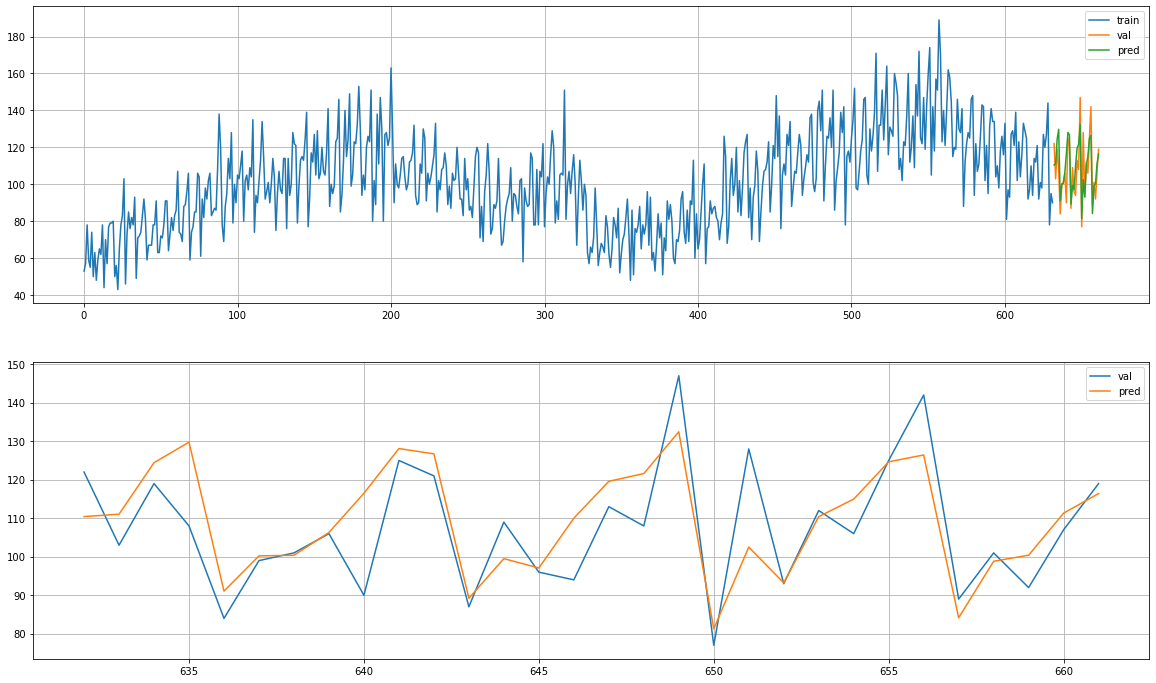

In [50]:
plot_model_result(y_train, y_val, pred)